## TOC:
* [DCT/IDCT](#first-bullet)
* [Zigzag/inverse Zigzag Scan](#2)
* [Run Length Encoding/Decoding](#3)
* [JPEG Encode/Decode](#4)
* [Specifications of compression](#specs)
* [Quantization Tables](#quant)
* [Loading image](#img)
* [Applying JPEG to image](#jpeg)
* [Quantitative assesment](#quantitative)
* [Qualitative assesment](#qualitative)
* [Compression Ratio](#ratio)
* [Discussion](#disc)
* [Conclusion](#conc)

In [159]:
from PIL import Image, ImageOps
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from huffman3 import Huffman

<a class="anchor" id="first-bullet"></a>
### Implement 2D DCT which is the core of the JPEG compression. It will receive a 2D matrix and return the 2D DCT of this matrix

In [110]:
def dct2D(mat):
    '''Apply 2D DCT on the input MxM matrix mat. This function operates by calculating the transform matrix T
    which can be used to calculate the 2D DCT using the following equation B = T*mat*T'.
    Returns 2D DCT matrix.'''
    
    #get the dimension of the new matrix
    M, _ = mat.shape
    def basis_func(r, c):
        '''Function used by numpy.fromfunction to compute the transform matrix'''
        M, _ = r.shape
        mat = np.sqrt(2 / M) * np.cos(np.pi * (2*c + 1) * r / (2 * M))
        mat[0,:] = mat[0,:] / np.sqrt(2);
        return mat
    #get the transform matrix
    basis = np.fromfunction(basis_func, (M,M))
    #matrix multiply transform matrix and input matrix
    temp = np.dot(basis, mat)
    #matrix multiply the temp matrix with the transpose of the transform matrix
    #return the result but use the original dimensions to truncate the zero padded area
    return np.dot(temp, basis.T)

### Implement 2D IDCT. It reverses 2D DCT by taking a 2D DCT matrix and returning the original 2D matrix before the transform

In [111]:
def idct2D(fmat):
    '''Apply 2D IDCT on the input MxM matrix mat. This function operates by calculating the transform matrix T
    which can be used to calculate the 2D IDCT using the following equation mat = T'*fmat*T.
    Returns 2D IDCT matrix.'''
    
    #get the dimension of the new matrix
    M, _ = fmat.shape
    def basis_func(r, c):
        '''Function used by numpy.fromfunction to compute the transform matrix'''
        M, _ = r.shape
        mat = np.sqrt(2 / M) * np.cos(np.pi * (2*c + 1) * r / (2 * M))
        mat[0,:] = mat[0,:] / np.sqrt(2);
        return mat
    #get the transform matrix
    basis = np.fromfunction(basis_func, (M,M))
    
    #matrix multiply transform matrix transpose and input matrix
    temp = np.dot(basis.T, fmat)
    #matrix multiply the temp matrix with the transform matrix
    #return the result but use the original dimensions to truncate the zero padded area
    return np.dot(temp, basis)

<a class="anchor" id="2"></a>
### Implement zigzag scan on a 2D martix. The zigzag scan is used to combine elements in the quantized 2D DCT, so that zeros in the high frequency regions can be grouped together to increase the efficiency of a run length coding.

In [112]:
def zigzag_scan(mat):
    '''Performs a zigzag scan for the given NxN numpy matrix. Returns a numpy array of the scanned elements.'''
    
    N = mat.shape[0]
    length = N*N
    #create the vector which will store the result of the zigzag scan
    v = np.zeros(length)
    #this variable will be used to index the vector
    index = 0
    #this variable will allow us to figure out whether we're going up or down in a certain diagonal
    direction = "up"
    for c in range(N):
        if direction == "up":
            #if we're going up then row index start with c and decrements down to zero,
            #while column index start from zero and increment up to c
            for n in range(c+1):
                v[index] = mat[c-n, n]
                #simultaneously fill the tail of the vector
                v[length-index-1] = mat[N-(c-n)-1, N-n-1]
                index += 1
            #revrse the direction for the next iteration
            direction = "down"
        else:
            #if we're going down then row index start with 0 and increment up to c,
            #while column index start with c and decrements down to zero
            for n in range(c+1):
                v[index] = mat[n, c-n]
                v[length-index-1] = mat[N-n-1, N-(c-n)-1]
                index += 1
            direction = "up"
    return v

### Implement inverse zigzag scan which can take a vector resulting from a zigzag scan on a 2D matrix and return this original matrix.

In [113]:
def inverse_zigzag_scan(v):
    '''Performs an inverse zigzag scan for the given NxN numpy matrix by placing elements from a vector into a 2D matrix.
    Returns a numpy matrix of the results.'''
    
    length = v.shape[0]
    #the dimension of the matrix is the square root of the length of the vector
    N = int(np.sqrt(length))
    #create the matrix which will store the result of the inverse zigzag scan
    mat = np.zeros((N, N))
    #this variable will be used to index the vector
    index = 0
    #this variable will allow us to figure out whether we're going up or down in a certain diagonal
    direction = "up"
    for c in range(N):
        if direction == "up":
            #if we're going up then row index start with c and decrements down to zero,
            #while column index start from zero and increment up to c
            for n in range(c+1):
                mat[c-n, n] = v[index]
                #simultaneously fill the tail of the vector
                mat[N-(c-n)-1, N-n-1] = v[length-index-1]
                index += 1
            #revrse the direction for the next iteration
            direction = "down"
        else:
            #if we're going down then row index start with 0 and increment up to c,
            #while column index start with c and decrements down to zero
            for n in range(c+1):
                mat[n, c-n] = v[index]
                mat[N-n-1, N-(c-n)-1] = v[length-index-1]
                index += 1
            direction = "up"
    return mat

<a class="anchor" id="3"></a>
### Implement run length encoding which makes use of the vector produced by the zigzag scan to run-length encode succesive zeros with a single zero and a number showing how many times to repeat it

In [114]:
def run_length_encode(vec):
    '''applies run length encoding to the given vector by replacing every sequence of zeros with
    a single zero and how much it is repeated. Returns the encoded vector'''
    
    length = len(vec)
    # init an empty list which will store the encoded sequence
    encoded = []
    # init an index
    i = 0
    while i < length:
        # if the current element in the input vector is zero => we need to perform encoding
        if vec[i] == 0:
            # init the count of zeros to 1
            c = 1
            # increment the index by one to inspect the next element
            i += 1
            # while the new element is zero and i is less than the length of the array
            while i < length and vec[i] == 0:
                # increment the count of zeros
                c += 1
                i += 1
            # store in the encoded array one zero and the count of zeros
            encoded += [0, c]
        else:
            # if the the current element is not zero then just add it to the encoded array
            encoded.append(vec[i])
            i += 1
    return encoded

### Implement run length decoding which takes a vector that has been run-length encoded before and expand it and return the original vector

In [115]:
def run_length_decode(vec):
    '''applies run length decoding to the given vector by expanding zeros according
    to the number stored next to them. Returns the decoded vector'''
    
    length = len(vec)
    # init an empty list which will store the decoded sequence
    decoded = []
    i = 0
    while i < length:
        # if the current element is zero
        if vec[i] == 0:
            # append to the decoded list n zero where n is the element after the zero
            decoded += [0] * vec[i+1]
            # incremnt i by 2 to skip the zero and the count
            i += 2
        else:
            # otherwise append the current element to the decoded sequence
            decoded.append(vec[i])
            i += 1
    return np.array(decoded)

In [116]:
def zero_pad(img):
    '''Zero pad the img matrix if needed to make the dimensions divisble by 8.
       Returns the new matrix and the new dimensions.'''
    
    # obtain the actual dimensions of the image
    R, C = img.shape
    # init the new dimensions with the current dimensions
    R_new, C_new = R, C
    # as long as the new row is not divisible by 8, keep incrementing it by 1
    while R_new % 8 != 0:
        R_new+=1
    # as long as the new col is not divisible by 8, keep incrementing it by 1
    while C_new % 8 != 0:
        C_new+=1
    # return the image padded with extra zeros, and return the new dimensions
    return np.pad(img, ((0, R_new - R), (0, C_new - C))), R_new, C_new

<a class="anchor" id="4"></a>
### Now we will create two functions for JPEG encoding/decoding that combines all the above functions to perfrom JPEG compression

In [117]:
def jpeg_encode(img, quant_table):
    '''Apply JPEG encoding on the img matrix using the given quantization table.
       Returns the encoded binary sequence'''
    
    # obtain the actual dimensions of the image matrix
    R_act, C_act = img.shape
    # zero pad the image if rows or columns are not divisible by 8
    img, R, C = zero_pad(img)
    
    # initialize the matrix that will store the result of dct of 8x8 blocks
    dct_img = np.zeros((R, C))
    for r in range(0, R, 8):
        for c in range(0, C, 8):
            # perform 2D dct for the given block and store the result in the dct_img matrix
            dct_img[r:r+8, c:c+8] = dct2D(img[r:r+8, c:c+8])
    
    # repeat the quantization table so that its size mathces exactly the dct_img matrix
    quant_matrix = np.tile(quant_table, (R//8, C//8))
    # quantize the dct matrix by dividing it by the quant matrix
    # and casting the resulting matrix to int to truncate the decimal part
    quant_dct_img = (dct_img/quant_matrix).astype(int)
    
    # initialize the vector that will store the result of zig zag scans for all 8x8 blocks
    img_vec = np.zeros((R*C), dtype=int)
    # init a variable that will be used to index the img_vec
    i = 0
    for r in range(0, R, 8):
        for c in range(0, C, 8):
            # perform zig zag scan for the quantized dct 8x8 block and store the 64 value vector in the img_vec
            img_vec[i:i+64] = zigzag_scan(quant_dct_img[r:r+8, c:c+8])
            i+=64
    
    # perform run length encoding
    img_vec_enc = run_length_encode(img_vec)
    # add a header that cocntains information about the dimensions of the image
    final_vec = np.concatenate(([R_act, C_act, R, C], img_vec_enc))
    # apply Huffman encoding to the final vector
    encoded_sequence, code_dict = Huffman().encode_sequence(final_vec)
    # return the encoded bit sequence and the code dictionary
    return encoded_sequence, code_dict

In [118]:
def jpeg_decode(encoded_sequence, code_dict, quant_table):
    '''Apply JPEG decoding on the encoded sequence using the given quantization table.
       Returns the decoded image matrix'''
    
    final_vec = Huffman().decode_sequence(encoded_sequence, code_dict)
    #remove the header of the vector that contains information about the dimensions of the image
    R_act, C_act, R, C = final_vec[:4]
    img_vec_enc = final_vec[4:]
    
    # perform run length decoding
    img_vec = run_length_decode(img_vec_enc)
    
    # init the quantized dct matrix of 8x8 blocks
    quant_dct_img = np.zeros((R,C))
    
    # init a variable that will be used to index the img_vec
    i = 0
    for r in range(0, R, 8):
        for c in range(0, C, 8):
            # perform inverse zig zag scan on the current 64 values of the img_vec and store
            # the resulting 8x8 matrix in the dct matrix
            quant_dct_img[r:r+8, c:c+8] = inverse_zigzag_scan(img_vec[i:i+64])
            i+=64
    
    # repeat the quantization table so that its size mathces exactly the dct_img matrix
    quant_matrix = np.tile(quant_table, (R//8, C//8))
    # rescale the current 8x8 dct block by multiplying it by the boradcasted quant matrix
    dct_img = quant_dct_img * quant_matrix
    
    # initialize the matrix that will store the image
    img = np.zeros((R, C))
    for r in range(0, R, 8):
        for c in range(0, C, 8):
            # perform 2D idct for the given 8x8 block to reconstruct the original 8x8 block in the image
            img[r:r+8, c:c+8] = idct2D(dct_img[r:r+8, c:c+8])
    # return the img matrix up to the actual dimensions (in case zero padding occured in the encoder)        
    return img[:R_act, :C_act]

<a class="anchor" id="specs"></a>
# Specs of compression:
<ol>
  <li>Achieve a compression ratio of 10:1.</li>
  <li>Achieve a Structural Similarity Index score of at least 0.8.</li>
  <li>Validate that for the given SSIM the visual quality of the image after compression is acceptable.</li>
</ol>

<a class="anchor" id="quant"></a>
### We will load three different quantization matrices from a text file. One of them corresponds to low compression and the rest correspond to high and extra high compression.

In [119]:
with open("quantization_tables.txt") as file:
        low_comp = [list(map(int, file.readline().strip().split())) for _ in range(8)]
        high_comp = [list(map(int, file.readline().strip().split())) for _ in range(8)]
        high_comp2 = [list(map(int, file.readline().strip().split())) for _ in range(8)]

In [120]:
# print the low compression quantization table
low_comp

[[1, 1, 1, 1, 1, 2, 2, 4],
 [1, 1, 1, 1, 1, 2, 2, 4],
 [1, 1, 1, 1, 2, 2, 2, 4],
 [1, 1, 1, 1, 2, 2, 4, 8],
 [1, 1, 2, 2, 2, 2, 4, 8],
 [2, 2, 2, 2, 2, 4, 8, 8],
 [2, 2, 2, 4, 4, 8, 8, 16],
 [4, 4, 4, 4, 8, 8, 16, 16]]

In [121]:
# print the high compression quantization table
high_comp

[[1, 2, 4, 8, 16, 32, 64, 128],
 [2, 4, 4, 8, 16, 32, 64, 128],
 [4, 4, 8, 16, 32, 64, 128, 128],
 [8, 8, 16, 32, 64, 128, 128, 256],
 [16, 16, 32, 64, 128, 128, 256, 256],
 [32, 32, 64, 128, 128, 256, 256, 256],
 [64, 64, 128, 128, 256, 256, 256, 256],
 [128, 128, 128, 256, 256, 256, 256, 256]]

In [122]:
# print the extra high compression quantization table
high_comp2

[[16, 11, 10, 16, 24, 40, 51, 61],
 [12, 12, 14, 19, 26, 58, 60, 55],
 [14, 13, 16, 24, 40, 57, 69, 56],
 [14, 17, 22, 29, 51, 87, 80, 62],
 [18, 22, 37, 56, 68, 109, 103, 77],
 [24, 35, 55, 64, 81, 104, 113, 92],
 [49, 64, 78, 87, 103, 121, 120, 101],
 [72, 92, 95, 98, 112, 100, 103, 99]]

# Justification of the above quantization tables
<ol>
  <li>Eye is most sensitive to low frequencies, and low frequencies are found on the upper left corner of a dct matrix. Therefore setting relativley low values in quantization matrix for low frequencies and high values for high frequencies means that we are more aggressivley quantizing the higher frequencies that will not affect the visual quality much.</li>
  <li>The first two quantization tabes are a direct implementation of the previously mentioned point with the first table having smaller numbers to favor better quality vs less compression.</li>
  <li>The third quantization table is on the quantization tables defined in the standard of JPEG, and by inspecting its values and comparing them with the first two tables it should favor more compression vs less quality</li>
</ol>

<a class="anchor" id="img"></a>
### Now, we will load an image and apply jpeg compression then decompression to it using three different quantization tables to asses how they differ.

Text(0.5, 1.0, 'Original Image')

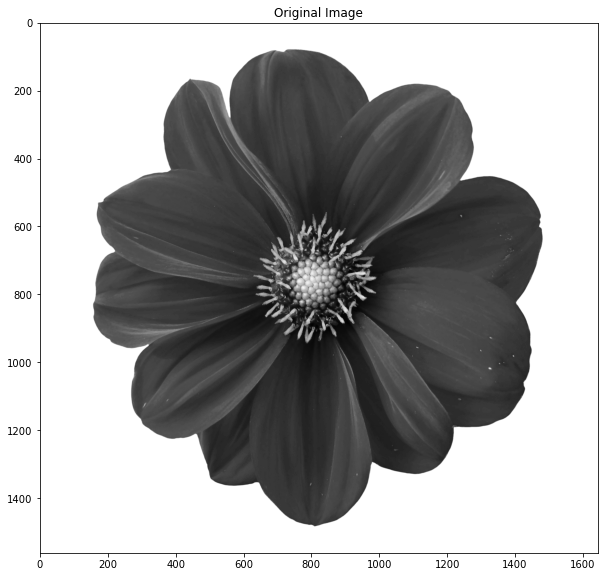

In [123]:
img = Image.open("flower.png")
#convert image to grayscale
img = ImageOps.grayscale(img)
#convert image to numpy ndarray
img = np.asarray(img)
img = img.astype('float64')

plt.figure(figsize=(10,10))
plt.imshow(img, cmap=cm.gray)
plt.title("Original Image")

<a class="anchor" id="jpeg"></a>
### Encode the image using the first quantization table, then decompress it to reproduce the original image after compression

Text(0.5, 1.0, 'Image After JPEG Compression With Low Quantization')

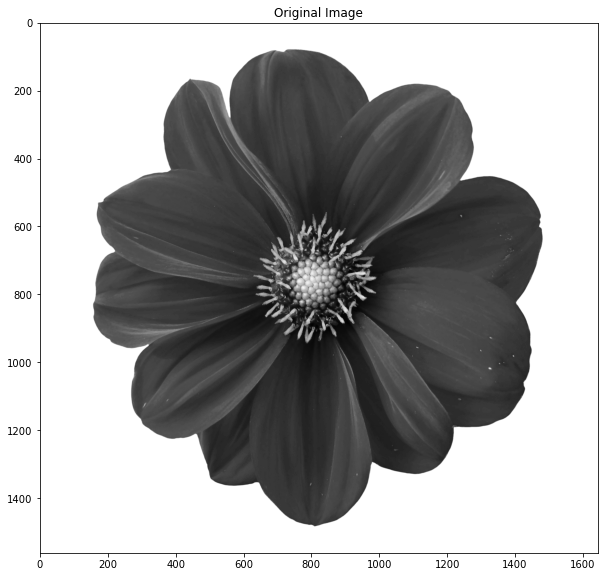

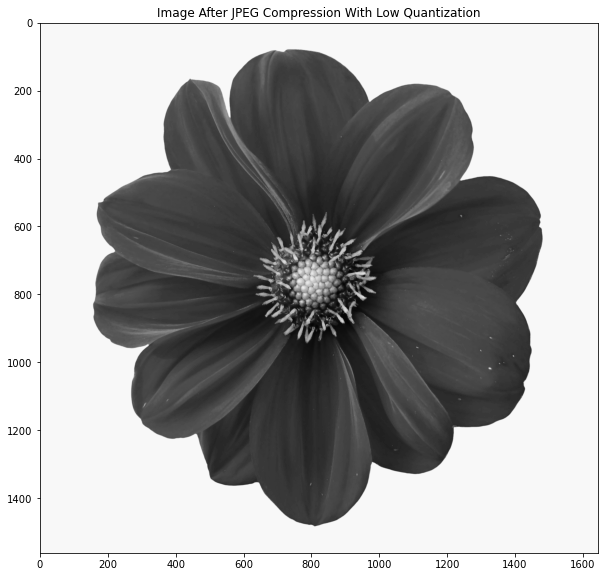

In [124]:
enc_low, code_dict = jpeg_encode(img, low_comp)
img_decomp_low = jpeg_decode(enc_low, code_dict, low_comp)

plt.figure(figsize=(10,10))
plt.imshow(img, cmap=cm.gray)
plt.title("Original Image")
plt.figure(figsize=(10,10))
plt.imshow(img_decomp_low, cmap=cm.gray)
plt.title("Image After JPEG Compression With Low Quantization")

### Encode the image using the second quantization table, then decompress it to reproduce the original image after compression

Text(0.5, 1.0, 'Image After JPEG Compression With High Quantization')

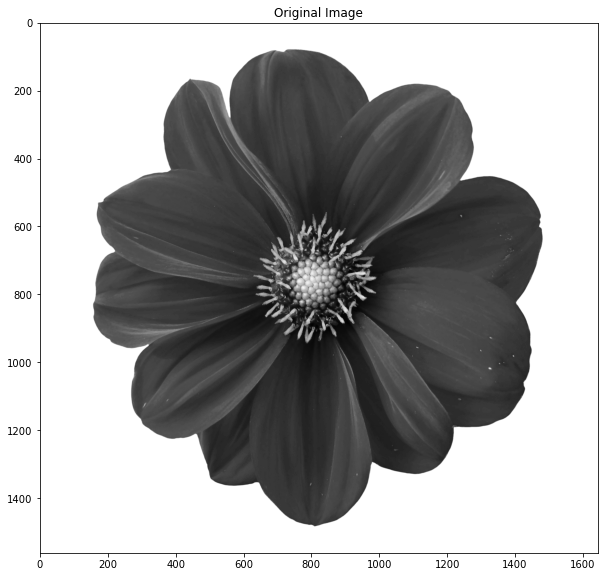

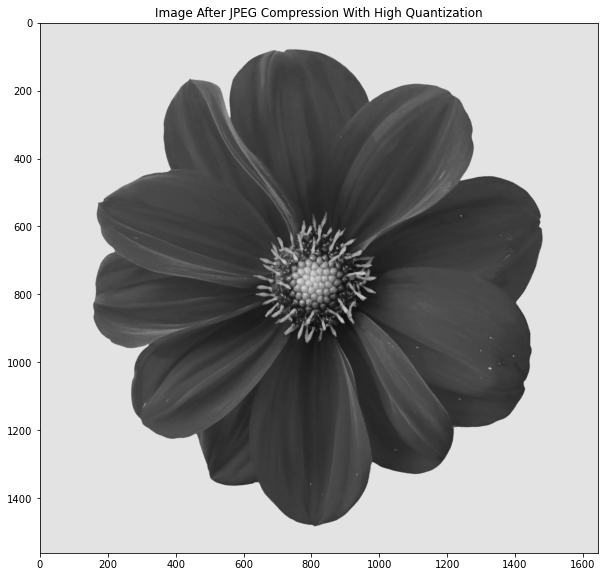

In [125]:
enc_high, code_dict = jpeg_encode(img, high_comp)
img_decomp_high = jpeg_decode(enc_high, code_dict, high_comp)

plt.figure(figsize=(10,10))
plt.imshow(img, cmap=cm.gray)
plt.title("Original Image")
plt.figure(figsize=(10,10))
plt.imshow(img_decomp_high, cmap=cm.gray)
plt.title("Image After JPEG Compression With High Quantization")

### Encode the image using the third quantization table, then decompress it to reproduce the original image after compression

Text(0.5, 1.0, 'Image After JPEG Compression With High Quantization')

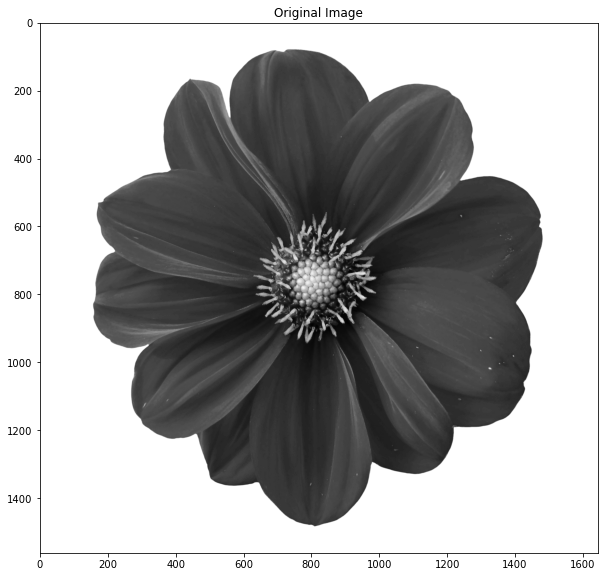

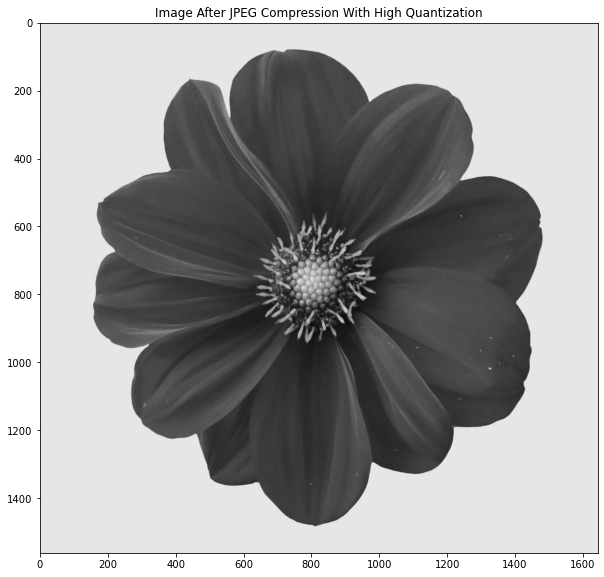

In [126]:
enc_high2, code_dict = jpeg_encode(img, high_comp2)
img_decomp_high2 = jpeg_decode(enc_high2, code_dict, high_comp2)

plt.figure(figsize=(10,10))
plt.imshow(img, cmap=cm.gray)
plt.title("Original Image")
plt.figure(figsize=(10,10))
plt.imshow(img_decomp_high2, cmap=cm.gray)
plt.title("Image After JPEG Compression With High Quantization")

<a class="anchor" id="quantitative"></a>
### To quantitaviley asses the quality of each version of the decompressed images we use the Structural Similarity Index (SSIM). This metric is superior than other metrics, because other metrics atteempt to quantify errors between reference and sample image by quantifying the difference in the values of each of the corresponding pixels between the sample and the reference images (By using, for example, Mean Squared Error). However, such metrics do not take into account how human eye perceive images, so a metric that attempts to measure key aspects of the images that human eyes are sensitive to like the SSIM.

### The SSIM score for each pair of reference-sample image is a value from 0 to 1, where 1 means that both images are identical and 0 means that images are very different. Thus, we want the decompressed image to have an SSIM score as close to 1 as possible.

SSIM score for low compression image 0.8931084320505627
SSIM score for high compression image 0.8120619526514558
SSIM score for extra high compression image 0.71361129113559


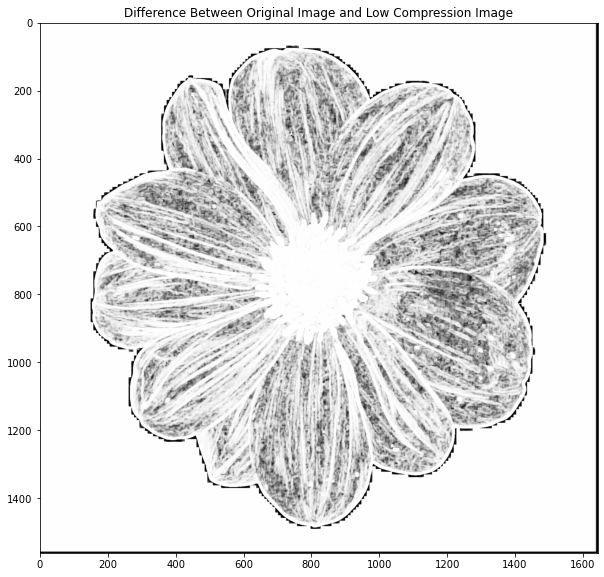

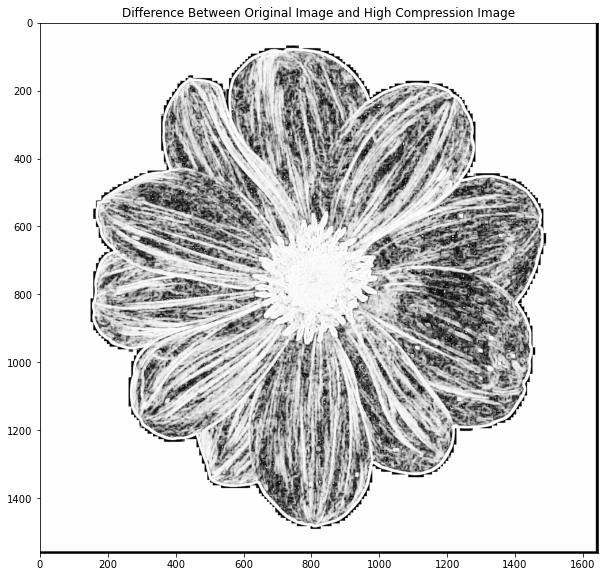

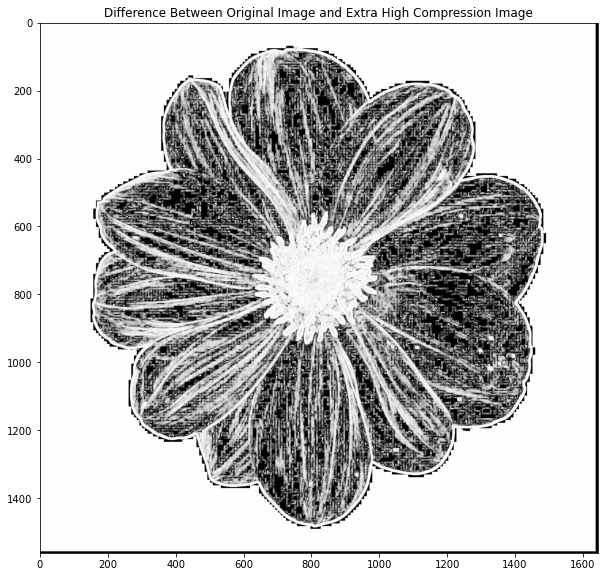

In [127]:
import skimage.metrics.simple_metrics

# calculate the SSIM score of each decompressed image
score1, diff1 = skimage.metrics.structural_similarity(img_decomp_low, img, full=True)
score2, diff2 = skimage.metrics.structural_similarity(img_decomp_high, img, full=True)
score3, diff3 = skimage.metrics.structural_similarity(img_decomp_high2, img, full=True)

plt.figure(figsize=(10,10))
plt.title("Difference Between Original Image and Low Compression Image")
plt.imshow((diff1 * 255).astype("uint8"), cmap=cm.gray)

plt.figure(figsize=(10,10))
plt.title("Difference Between Original Image and High Compression Image")
plt.imshow((diff2 * 255).astype("uint8"), cmap=cm.gray)

plt.figure(figsize=(10,10))
plt.title("Difference Between Original Image and Extra High Compression Image")
plt.imshow((diff3 * 255).astype("uint8"), cmap=cm.gray)

print("SSIM score for low compression image", score1)
print("SSIM score for high compression image", score2)
print("SSIM score for extra high compression image", score3)

<a class="anchor" id="qualitative"></a>
### Qualitative analysis of each version of the decompressed images
To asses the visual quality of each image we need to zoom in a little bit to a certain section of the image. After zooming in we can assess how much the fine details of the image are preserved after compression.

Text(0.5, 1.0, 'Image after extra high compression')

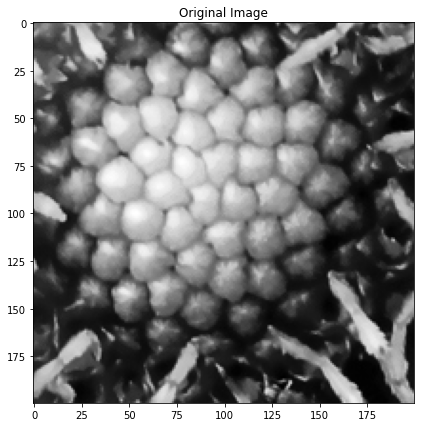

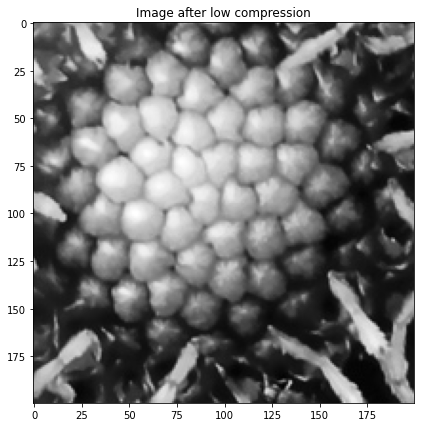

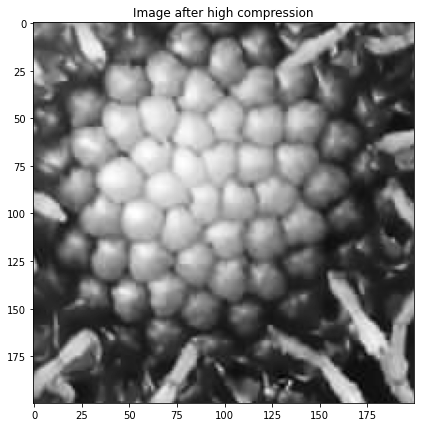

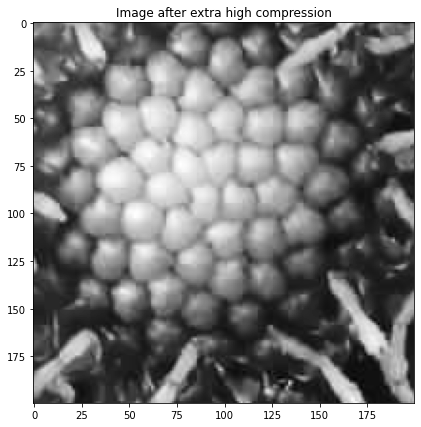

In [166]:
plt.figure(figsize=(7,7))
plt.imshow(img[781-100:781+100,  822-100:822+100], cmap=cm.gray)
plt.title("Original Image")

plt.figure(figsize=(7,7))
plt.imshow(img_decomp_low[781-100:781+100,  822-100:822+100], cmap=cm.gray)
plt.title("Image after low compression")

plt.figure(figsize=(7,7))
plt.imshow(img_decomp_high[781-100:781+100,  822-100:822+100], cmap=cm.gray)
plt.title("Image after high compression")

plt.figure(figsize=(7,7))
plt.imshow(img_decomp_high2[781-100:781+100,  822-100:822+100], cmap=cm.gray)
plt.title("Image after extra high compression")

<a class="anchor" id="ratio"></a>
### Now we will calculate the compression ratio using each quantization table

In [169]:
# get the dimensions of the image
r, c = img.shape
# the number of bits needed to store one pixel before compression is 8 bits, and we have r*c bits
bits_before = 8*r*c

# the number of bits needed for the whole image after compression is the length of the binary sequence
# after performing Huffman

bits_after_low = len(enc_low)
bits_after_high = len(enc_high)
bits_after_high2 = len(enc_high2)

# compression ratio is calculated by bits before / bits after
cr_low = bits_before / bits_after_low
cr_high = bits_before / bits_after_high
cr_high2 = bits_before / bits_after_high2

print("Compression ratio using the low compression quantization table = %d:1" % (round(cr_low)))
print("Compression ratio using the high compression quantization table = %d:1" % (round(cr_high)))
print("Compression ratio using the extra high compression quantization table = %d:1" % (round(cr_high2)))

Compression ratio using the low compression quantization table = 7:1
Compression ratio using the high compression quantization table = 17:1
Compression ratio using the extra high compression quantization table = 28:1


<a class="anchor" id="disc"></a>
# Discussion:
<ol>
  <li>According to the quantitative assesment, the SSIM score of the image after extra high compression does not follow our specification since its score is below 0.8.</li>
    <li>According to the qualitative assesment, the image after extra high compression is very blurry. On the other hand, the image after low compression does retain most of the sharpness of the original image. The image after high compression falls somwhere in between, but there is a noticebale loss of details when compared with the original image</li>
    <li>The compression ratio of the image after low compression does not strictly follow our specification of 10:1, while the other images achieved a relativley large compression rate</li>
</ol>

<a class="anchor" id="conc"></a>
# Conclusion:
Although the first quantization table did not accuratley meet our specification for compression ratio, however when weighing out all factors such as SSIM score, visual assesment, and compression ratio it is clear that the first quantization table is the closest result to our specification. The second quantization does actually meet our specification or SSIM score, but the compression ratio is much larger than the specification which caused the image to lack a lot of sharpness as compared with the original image

### Save the original grayscale version of the image and the three images after decompression

In [167]:
plt.imsave("flower_low_comp.jpg", img_decomp_low, cmap=cm.gray)
plt.imsave("flower_high_comp.jpg", img_decomp_high, cmap=cm.gray)
plt.imsave("flower_extra_high_comp.jpg", img_decomp_high2, cmap=cm.gray)
plt.imsave("flower.jpg", img, cmap=cm.gray)